# Balance and Sequentiality in Bayesian Analyses

In Alison Bechdel's 1985 comic strip The Rule, a character states that they only see a movie if it satisàes the following three rules ([Bechdel test Wiki](https://en.wikipedia.org/wiki/Bechdel_test)):
- the movie has to have at least two women in it.
- these two women talk to each other
- they talk about something besides a man.

These criteria constitute the Bechdel test for the representation of women in film. Thinking of movies you've watched, what percentage of all recent movies do you think pass the Bechdel test? Is it closer to 10%, 50%, 80%, or 100%? Let π, a random value between 0 and 1, denote the unknown proportion of movies that pass the Bechdel test.

### Goals 
- **Explore the balanced ináuence of the prior and data on the posterior.** You will see how our choice of prior model, the features of our data, and the delicate balance between them can impact the posterior model.
- **Perform sequential Bayesian analysis.** You will explore one of the coolest features of Bayesian analysis: how a posterior model evolves as it's updated with new data.

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import beta
from scipy.stats import binom
from scipy.stats import uniform
from empiricaldist import Pmf

import utils as ut

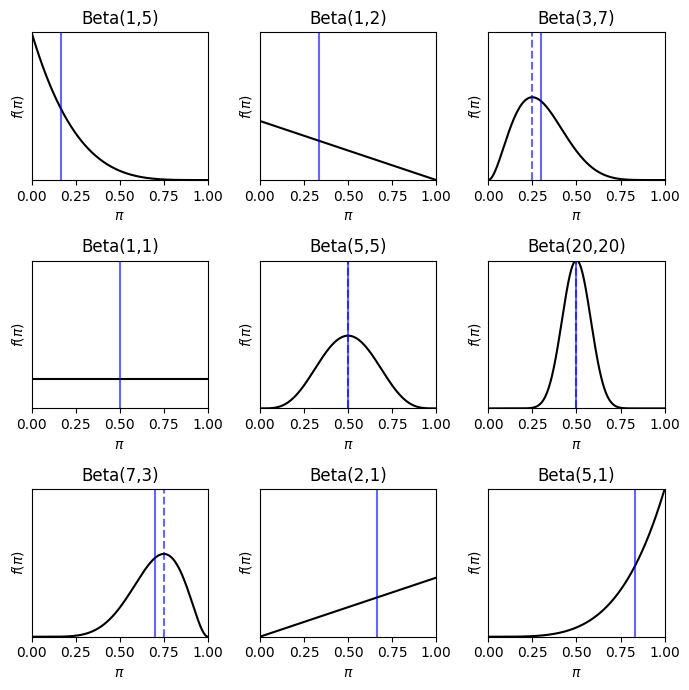

In [49]:
ut.get_gamma_plots()

### [5 mins task!] Create your own prior based on your knowledge and past experience.

In [ ]:
#solution

alpha_1, beta_1 = [1,5]
alpha_2, beta_2 = [1,1]
alpha_3, beta_3 = [5,1]

# Different Priors, Different Posteriors

We consider three different prior beliefs regarding the proportion of movies passing the Bechdel test:

- The **feminist** believes the proportion is low, modeled by a $Beta({alpha_1},{{ beta_1 }} )$ prior.
- The **clueless** has no strong prior belief, modeled by a $Beta({{alpha_2}},{{beta_2}})$ (Uniform) prior.
- The **optimist** believes the proportion is high, modeled by a $Beta({{alpha_3}},{{beta_3}})$ prior.

These priors are visualized below.

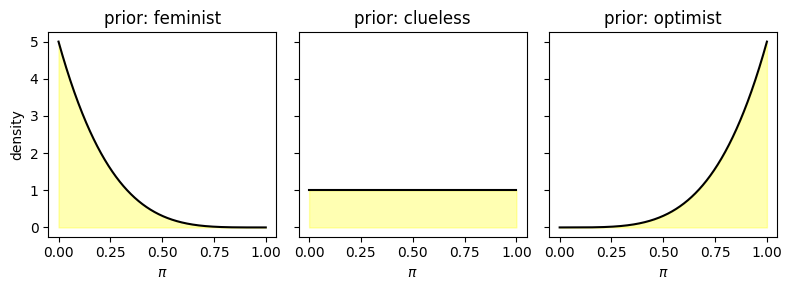

In [51]:
# Define prior distributions
x = np.linspace(0, 1, 1000)
priors = {
    "feminist": beta.pdf(x, alpha_1, beta_1),
    "clueless": beta.pdf(x, alpha_2, beta_2),
    "optimist": beta.pdf(x, alpha_3, beta_3), 
}

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(8, 3), sharey=True)

# Plot each prior
for ax, (label, y) in zip(axes, priors.items()):
    ax.plot(x, y, color="black")
    ax.fill_between(x, y, alpha=0.3, color="yellow")
    ax.set_title(f"prior: {label}")
    ax.set_xlabel(r"$\pi$")
    ax.grid(False)

axes[0].set_ylabel("density")

plt.tight_layout()
plt.show()


The three analysts agree to review a sample of n recent movies and record Y, the number that pass the Bechdel test. Recognizing Y as the number of “successes” in a fixed number of independent trials, they specify the dependence of Y on π using a Binomial model. Thus, each analyst has a unique Beta-Binomial model of π with differing prior hyperparameters α and β:

$$ Y | \pi \sim \text{Bin}(n, \pi) $$
$$ \pi \sim \text{Beta}(\alpha_i,\beta_i) $$
$$ \pi | (Y = y) \sim \text{Beta}(\alpha_i + y, \beta_i + n - y) $$

If you're thinking **“Can everyone have their own prior?! Is this always going to be so subjective?!”**, you are asking **THE RIGHT QUESTION!** And the questions don't end there. To what extent might their different priors lead the analysts to three different posterior conclusions about the Bechdel test? How might this depend upon the sample size and outcomes of the movie data they collect? To what extent will the analysts' posterior understandings evolve as they collect more and more data? Will they ever come to agreement about the representation of women in film?! We will examine these fundamental questions throughout this class, continuing to build our capacity to **think like Bayesians**.

<div style="background-color:#e0e1e0; padding:10px; border:5px solid #737773; color:black">
    
### Informative prior

#### An informative prior reflects specific information about the unknown variable with high certainty, i.e., low variability.

</div>

<div style="background-color:#e0e1e0; padding:10px; border:5px solid #737773; color:black">
    
### Vague prior

#### A vague or diffuse prior reflects little specific information about the unknown variable. A flat prior, which assigns equal prior plausibility to all possible values of the variable, is a special case.

</div>

The next natural question to ask is: how will their different priors influence the posterior conclusions of the feminist, the clueless, and the optimist? To answer this question, we need some data. Our analysts decide to review a random sample of n = 20 recent movies using data collected from [bechdeltest.com](https://bechdeltest.com/).

## Get your data

In [52]:
# the dataset Bechdel_detailed.csv i'm using was generated by 
# https://www.kaggle.com/datasets/alisonyao/movie-bechdel-test-scores?resource=download&select=Bechdel_detailed.csv

bechdel_detail_df = pd.read_csv('./data/Bechdel_detailed.csv', index_col=0)
bechdel_detail_df

,title,year,rating,dubious,imdbid,id,submitterid,date,visible
0,Passage de Venus,1874.0,0.0,0.0,3155794.0,9602.0,18880.0,2021-04-02 20:58:09,1.0
1,La Rosace Magique,1877.0,0.0,0.0,14495706.0,9804.0,19145.0,2021-05-11 00:11:22,1.0
2,Sallie Gardner at a Gallop,1878.0,0.0,0.0,2221420.0,9603.0,18882.0,2021-04-03 02:25:27,1.0
3,Le singe musicien,1878.0,0.0,0.0,12592084.0,9806.0,19151.0,2021-05-11 23:38:54,1.0
4,Athlete Swinging a Pick,1881.0,0.0,0.0,7816420.0,9816.0,19162.0,2021-05-13 01:32:14,1.0
...,...,...,...,...,...,...,...,...,...
9368,Love Hard,2021.0,2.0,0.0,10752004.0,10152.0,19735.0,2021-12-05 19:22:20,1.0
9369,Cruella,2021.0,3.0,0.0,3228774.0,9861.0,19231.0,2021-06-01 03:16:58,1.0
9370,West Side Story,2021.0,3.0,0.0,3581652.0,10157.0,19743.0,2021-12-10 03:10:09,1.0
9371,Every Time a Bell Rings,2021.0,3.0,0.0,15943414.0,10158.0,19744.0,2021-12-10 08:03:02,1.0


**Variable** --- Description

- **title** --- The title of the movie. Any weird characters are HTML encoded (so Brüno is returned as "Br&uuml;no").
- **year** --- The year this movie was released (according to IMDb).
- **rating** --- The actual score. Number from 0 to 3 (0 means no two women, 1 means no talking, 2 means talking about a man, 3 means it passes the test).
- **dubious** --- Whether the submitter considered the rating dubious.
- **imdbid** --- The IMDb id.
- **id** --- The bechdeltest.com unique id.
- **submitterid** --- The ID of the submitter. Since submitter information is currently not available through the API, is of no use.
- **date** --- The date this movie was added to the list
- **visible** ---	Has this movie been approved (currently only approved movies are returned, so this value will always be 1).

In [53]:
n=20
data1=ut.get_sample(bechdel_detail_df, n=n, random_state=42)
data1

,title,year,rating,dubious,imdbid,id,submitterid,date,visible
866,Funny Face,1957.0,3.0,0.0,50419.0,1747.0,2210.0,2010-11-10 08:18:08,1.0
1252,Peppermint Frappe,1967.0,1.0,0.0,62113.0,7513.0,14670.0,2017-03-14 12:57:02,1.0
1324,"They Shoot Horses, Don&#39;t They?",1969.0,1.0,1.0,65088.0,6794.0,13338.0,2016-03-26 07:33:00,1.0
1312,"Prime of Miss Jean Brodie, The",1969.0,3.0,0.0,64840.0,2456.0,3620.0,2011-06-29 13:02:25,1.0
1366,Wanda,1970.0,3.0,1.0,67961.0,9082.0,17867.0,2020-04-15 23:09:56,1.0
1600,"Count of Monte-Cristo, The",1975.0,1.0,0.0,72824.0,9823.0,19169.0,2021-05-13 21:44:59,1.0
1653,A Special Day,1977.0,2.0,0.0,76085.0,3366.0,5391.0,2012-06-17 23:59:08,1.0
1717,Jaws 2,1978.0,2.0,0.0,77766.0,7223.0,14142.0,2016-10-28 22:14:50,1.0
1901,Koyaanisqatsi,1982.0,0.0,0.0,85809.0,4079.0,7013.0,2013-04-22 11:56:09,1.0
2032,Once Upon A Time In America,1984.0,1.0,0.0,87843.0,6293.0,12180.0,2015-06-05 05:32:48,1.0


Consider the likelihood distribution based on your data

In [54]:
pass_test = np.shape(data1[data1['rating']==3])[0]
not_pass_test = n-pass_test
print('pass the test:', pass_test, 'and do not:', not_pass_test, 'movies')

pass the test: 9 and do not: 11 movies


### Define your likelihood distribution

The likelihood distribution, based on the data is a Bin$(n,0.45)$ where we used $Y=9$ and $n=20$

In [55]:
# solution
likelihood = binom.pmf(pass_test, n, x)

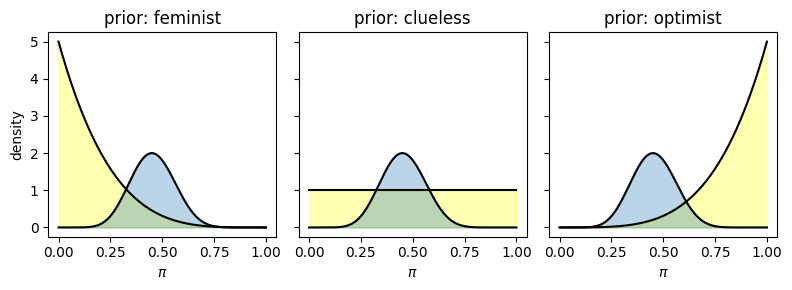

In [56]:
# Define prior distributions
x = np.linspace(0, 1, 1000)
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(8, 3), sharey=True)

# Plot each prior
for ax, (label, y) in zip(axes, priors.items()):
    ax.plot(x, y, color="black")
    ax.fill_between(x, y, alpha=0.3, color="yellow")
    ax.plot(x, likelihood/likelihood.max()*2, color="black")
    ax.fill_between(x, likelihood/likelihood.max()*2, alpha=0.3, color="tab:blue")
    ax.set_title(f"prior: {label}")
    ax.set_xlabel(r"$\pi$")
    ax.grid(False)

axes[0].set_ylabel("density")

plt.tight_layout()
plt.show()


### Get your posterior

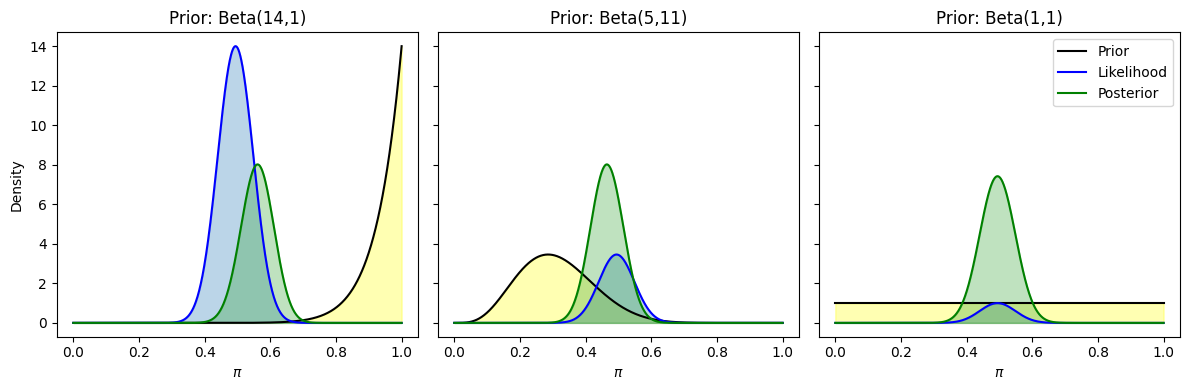

In [66]:
# Define a range of values for π
pi_values = np.linspace(0, 1, 1000)

# Create the figure
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

# Plot each prior, likelihood, and posterior
for ax, (label, (alpha_prior, beta_prior)) in zip(axes, priors.items()):
    # Calculate the prior
    prior = beta.pdf(pi_values, alpha_prior, beta_prior)
    
    # Calculate the likelihood
    likelihood = binom.pmf(y, n, pi_values)
    
    # Calculate the posterior
    posterior_alpha = alpha_prior + y
    posterior_beta = beta_prior + n - y
    posterior = beta.pdf(pi_values, posterior_alpha, posterior_beta)
    
    # Plot the prior
    ax.plot(pi_values, prior, color="black", label="Prior")
    ax.fill_between(pi_values, prior, alpha=0.3, color="yellow")
    
    # Plot the likelihood
    ax.plot(pi_values, likelihood / max(likelihood) * max(prior), color="blue", label="Likelihood")
    ax.fill_between(pi_values, likelihood / max(likelihood) * max(prior), alpha=0.3, color="tab:blue")
    
    # Plot the posterior
    ax.plot(pi_values, posterior, color="green", label="Posterior")
    ax.fill_between(pi_values, posterior, alpha=0.3, color="tab:green")
    
    # Set titles and labels
    ax.set_title(f"Prior: {label}")
    ax.set_xlabel(r"$\pi$")
    ax.grid(False)

axes[0].set_ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

or we can use theory to obtain the pdf of the posterior distribution since we know that we are dealing with a beta prior and a binomial likelihood. Then,
$$\hat{\alpha_1} = \alpha + y = \alpha_1 + 9$$
$$\hat{\beta_1} = \beta + n - y = \beta_1 + 20 - 9$$

and the posterior por the feminist prior will be Beta(14,22). Using the same idea, the other posterior distribution will be Beta(10,12) for the clueless and Beta(23,12) for the optimistic.

# Different data, different posteriors

If you're concerned by the fact that our three analysts have differing posterior understandings of π, the proportion of recent movies that pass the Bechdel, don't despair yet. Don't forget the role that data plays in a Bayesian analysis. To examine these dynamics, consider three new analysts – Ella, Hiromi, and Jaco – who all share the optimistic Beta(14,1) prior for π but each have access to different data. Ella reviews n = 14 movies from different years, among which Y = 6 (about 43%) pass the Bechdel test. Hiromi reviews n = 63 movies, among which Y = 28 (about 45%) pass the Bechdel test and Jaco reviews n = 99 movies, among which Y = 44 (about 45%) pass the Bechdel test.

In [58]:
Ella_set = ut.get_sample(bechdel_detail_df,n=14, random_state=42)
Hiromi_set = ut.get_sample(bechdel_detail_df,n=63, random_state=42)
Jaco_set = ut.get_sample(bechdel_detail_df,n=99, random_state=42)

[Ella](https://www.youtube.com/watch?v=myRc-3oF1d0)

[Hiromi](https://www.youtube.com/watch?v=pnISpahN2dM)

[Jaco](https://www.youtube.com/watch?v=M-oechipx_M)

What a coincidence! Though Ella, Hiromi, and Jaco have collected different data, each observes a Bechdel pass rate of roughly 44%. Yet their sample sizes n differ – Ella only reviewed 14 movies whereas Jaco reviewed 99. 

### Before doing any formal math, check your intuition about how this different data will lead to different posteriors for the three analysts.

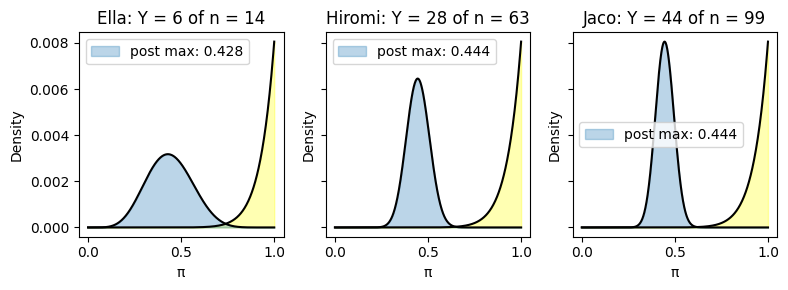

In [ ]:
# Define the prior: a Beta distribution
alpha_prior, beta_prior = 14, 1 

# Data for each analyst
analysts = {
    "Ella": {"y": 6, "n": 14},
    "Hiromi": {"y": 28, "n": 63},
    "Jaco": {"y": 44, "n": 99},
}

# Define a range of values for π
pi_values = np.linspace(0, 1, 1000)

fig, axes = plt.subplots(1, 3, figsize=(8, 3), sharey=True)
ml=0
for ax, (name, data) in zip(reversed(axes), reversed(analysts.items())):
    y, n = data["y"], data["n"]
    likelihood = Pmf(binom.pmf(y, n, pi_values))
    likelihood.normalize()
    prior = beta.pdf(pi_values, alpha_prior, beta_prior)
    
    if ml<max(likelihood):
        ml=max(likelihood)

    ax.plot(pi_values, prior/max(prior)*ml, color="black")
    ax.fill_between(pi_values, prior/max(prior)*ml , alpha=0.3 , color="yellow")
    ax.plot(pi_values, likelihood, color="black")
    ax.fill_between(pi_values, likelihood, alpha=0.3, color="tab:blue", label= f"post max: {likelihood.argmax()/1000}")

    ax.set_title(f"{name}: Y = {y} of n = {n}")
    ax.set_xlabel("π")
    ax.set_ylabel("Density")
    ax.legend()

plt.tight_layout()
plt.show()


#### Whose posterior do you anticipate will be most in sync with their data, as visualized by the scaled likelihood? 

#### Whose posterior do you anticipate will be the least in sync with their data?

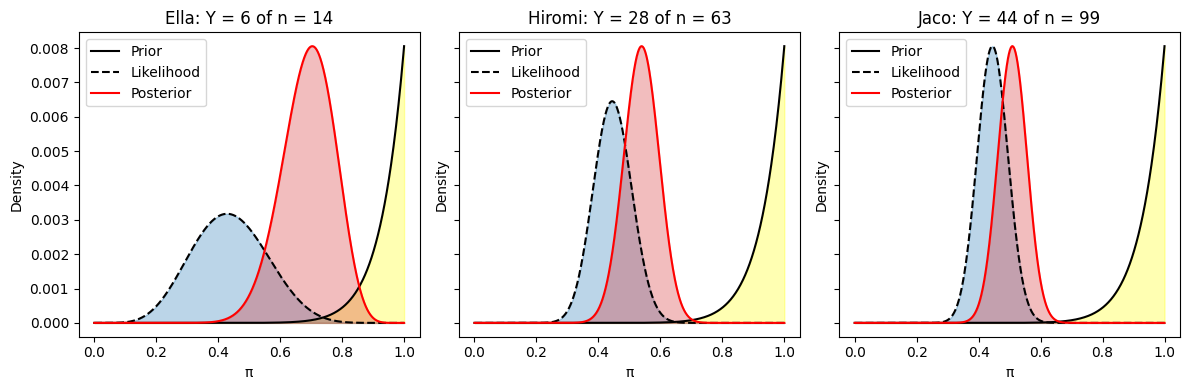

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta, binom
from empiricaldist import Pmf

# Define the prior: a Beta distribution
alpha_prior, beta_prior = 14, 1 

# Data for each analyst
analysts = {
    "Ella": {"y": 6, "n": 14},
    "Hiromi": {"y": 28, "n": 63},
    "Jaco": {"y": 44, "n": 99},
}

# Define a range of values for π
pi_values = np.linspace(0, 1, 1000)

fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
ml = 0
for ax, (name, data) in zip(reversed(axes), reversed(analysts.items())):
    y, n = data["y"], data["n"]
    likelihood = Pmf(binom.pmf(y, n, pi_values))
    likelihood.normalize()
    prior = beta.pdf(pi_values, alpha_prior, beta_prior)
    
    if ml < max(likelihood):
        ml = max(likelihood)

    posterior = prior * likelihood
    posterior /= posterior.sum()  # Normalize the posterior

    ax.plot(pi_values, prior / max(prior) * ml, color="black", label="Prior")
    ax.fill_between(pi_values, prior / max(prior) * ml, alpha=0.3, color="yellow")
    ax.plot(pi_values, likelihood, color="black", linestyle='--', label="Likelihood")
    ax.fill_between(pi_values, likelihood, alpha=0.3, color="tab:blue")
    ax.plot(pi_values, posterior / max(posterior) * ml, color="red", label="Posterior")
    ax.fill_between(pi_values, posterior / max(posterior) * ml, alpha=0.3, color="tab:red")

    ax.set_title(f"{name}: Y = {y} of n = {n}")
    ax.set_xlabel("π")
    ax.set_ylabel("Density")
    ax.legend()

plt.tight_layout()
plt.show()

### Summary plot

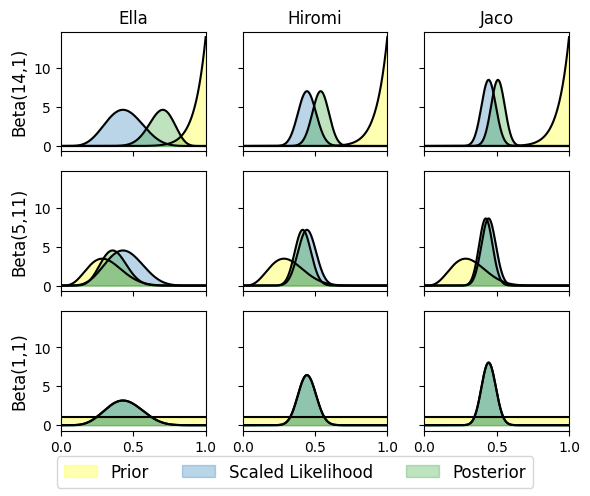

In [72]:
# Define updated priors from the original plot
priors = {
    "Beta(14,1)": (14, 1),
    "Beta(5,11)": (5, 11),
    "Beta(1,1)": (1, 1),  # Uniform prior
}

# Define colors
prior_color = "yellow"
likelihood_color = "tab:blue"
posterior_color = "tab:green"
line_color = "black"

# Create the figure
fig, axes = plt.subplots(3, 3, figsize=(6, 5), sharex=True, sharey=True)

for row, (prior_name, (alpha_prior, beta_prior)) in enumerate(priors.items()):
    for col, (data_label, data) in enumerate(analysts.items()):
        y, n = data["y"], data["n"]
        likelihood = binom.pmf(y, n, pi_values)
        posterior_alpha, posterior_beta = alpha_prior + y, beta_prior + (n - y)
        posterior = beta.pdf(pi_values, posterior_alpha, posterior_beta)
        prior = beta.pdf(pi_values, alpha_prior, beta_prior)

        ax = axes[row, col]
        
        # Fill the area under the curves
        ax.fill_between(pi_values, prior, color=prior_color, alpha=0.3, label="Prior")
        ax.fill_between(pi_values, likelihood / max(likelihood) * max(posterior), color=likelihood_color, alpha=0.3, label="Scaled Likelihood")
        ax.fill_between(pi_values, posterior, color=posterior_color, alpha=0.3, label="Posterior")

        # Plot the curves in black
        ax.plot(pi_values, prior, color=line_color)
        ax.plot(pi_values, likelihood / max(likelihood) * max(posterior), color=line_color)
        ax.plot(pi_values, posterior, color=line_color)

        if row == 0:
            ax.set_title(data_label, fontsize=12)
        if col == 0:
            ax.set_ylabel(f"{prior_name}", fontsize=12)
        
        ax.set_xlim(0, 1)

# Create a single legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=3, fontsize=12)
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()


Moving from left to right across the grid, the sample size increases from n = 14 to n = 99 movies while preserving the proportion of movies that pass the Bechdel test (Y /n ≈ 0.45). The likelihood's insistence and, correspondingly, the data's influence over the posterior increase with sample size n. This also means that the influence of our prior understanding diminishes as we amass new data. Further, the rate at which the posterior balance tips in favor of the data depends upon the prior. Moving from top to bottom across the grid, the priors move from informative (Beta(14,1)) to vague (Beta(1,1)). Naturally, the more informative the prior, the greater its influence on the posterior.

## Connecting Concepts to Theory

The patterns we've observed in the posterior balance between the prior and data are intuitive. They're also supported by an elegant mathematical result. If you're interested in supporting your intuition with theory, read on. If you'd rather skip the technical details, you can continue without major consequence.

Consider the general Beta-Binomial setting where ($\pi$) is the success rate of some event of interest with a ($Beta(\alpha, \beta)$) prior. Then, the posterior model of ($\pi$) upon observing (Y = y) successes in (n) trials is 

$$\pi | (Y = y) \sim Beta(\alpha + y, \beta + n - y)$$

It follows that the central tendency in our posterior understanding of ($\pi$) can be measured by the posterior mean,

$$E(\pi | Y = y) = \frac{\alpha + y}{\alpha + \beta + n}$$

And with a little rearranging, we can isolate the influence of the prior and observed data on the posterior mean. The second step in this rearrangement might seem odd, but notice that we're just multiplying both fractions by 1 (e.g., ($n/n$)).

$$E(\pi | Y = y) = \frac{\alpha}{\alpha + \beta + n} + \frac{y}{\alpha + \beta + n}$$

$$= \left(\frac{\alpha + \beta}{\alpha + \beta + n}\right) \left(\frac{\alpha}{\alpha + \beta}\right) + \left(\frac{n}{\alpha + \beta + n}\right) \left(\frac{y}{n}\right)$$

We've now split the posterior mean into two pieces: a piece which depends upon the prior mean ($E(\pi)$) and a piece which depends upon the observed success rate in our sample trials, ($y/n$). In fact, the posterior mean is a weighted average of the prior mean and sample success rate, their distinct weights summing to 1:

$$E(\pi | Y = y) = \left(\frac{\alpha + \beta}{\alpha + \beta + n}\right)E(\pi) + \left(\frac{n}{\alpha + \beta + n}\right) \frac{y}{n}$$

For example, consider the posterior means for Ella and Jaco. With a shared ($Beta(14,1)$) prior for ($\pi$), Ella and Jaco share a prior mean of ($E(\pi) = 14/15$). Yet their data differs. Ella observed (Y = 6) of (n = 14) films pass the Bechdel test, and thus has a posterior mean of

$$E(\pi | Y = 6) = \left(\frac{14+1}{14+1+14}\right)E(\pi) + \left(\frac{14}{14+1+14}\right) \frac{6}{14}$$

$$= 0.5172 \times \frac{14}{15} + 0.4827 \times \frac{6}{14}$$

$$= 0.6896.$$

Jaco observed (Y = 44) of (n = 99) films pass the Bechdel test, and thus has a posterior mean of

$$E(\pi | Y = 44) = \left(\frac{14+1}{14+1+99}\right)E(\pi) + \left(\frac{99}{14+1+99}\right) \frac{44}{99}$$

$$= 0.1316 \times \frac{14}{15} + 0.8684 \times \frac{44}{99}$$

$$= 0.5087.$$

Again, though Ella and Jaco have a common prior mean for ($\pi$) and observed similar Bechdel pass rates of roughly 45%, their posterior means differ due to their differing sample sizes (n). Since Ella observed only ($n = 14$) films, his posterior mean put slightly more weight on the prior mean than on the observed Bechdel pass rate in his sample: 0.5172 vs 0.4827. In contrast, since Jaco observed a relatively large number of ($n = 99$) films, his posterior mean put much less weight on the prior mean than on the observed Bechdel pass rate in his sample: 0.1316 vs 0.8684.

The implications of these results are mathemagical. In general, consider what happens to the posterior mean as we collect more and more data. As sample size (n) increases, the weight (hence influence) of the ($Beta(\alpha, \beta)$) prior model approaches 0,

$$\frac{\alpha + \beta}{\alpha + \beta + n} \to 0  \text{ as } n \to \infty,$$

while the weight (hence influence) of the data approaches 1,

$$\frac{n}{\alpha + \beta + n} \to 1  \text{ as } n \to \infty.$$

Thus, the more data we have, the more the posterior mean will drift toward the trends exhibited in the data as opposed to the prior:

$$E(\pi | Y = y) \to \frac{y}{n}  \text{ as } n \to \infty.$$

The rate at which this drift occurs depends upon whether the prior tuning (i.e., $\alpha$ and $\beta$) is informative or vague. Thus, these mathematical results support the observations we made about the posterior's balance between the prior and data previous figures. And that's not all! You can also show that the posterior mode can be written as the weighted average of the prior mode and observed sample success rate:

$$Mode(\pi | Y = y) = \left(\frac{\alpha + \beta - 2}{\alpha + \beta + n - 2}\right) Mode(\pi) + \left(\frac{n}{\alpha + \beta + n - 2}\right) \frac{y}{n}.$$



## Don't be stubborn

Bayesian philosophy provides the framework and flexibility for our understanding to evolve over time. One of the only ways to lose this Bayesian benefit is by starting with an extremely **stubborn prior model**. A model so stubborn that it assigns a prior probability of zero to certain parameter values. Consider our  example, where π is the proportion of movies that pass the Bachdel test. Suppose that a certain analyst has a stubborn belief in the good of humanity, insisting that π is equally likely to be anywhere between 0.65 and 1, and surely is never less than 0.65. They express this prior understanding through a Uniform model on 0.65 to 1,

$$\pi \sim \text{Unif}\big(0.65, 1\big)$$

Then, the analyst get the following data

In [62]:
N=85
stubborn_data = ut.get_sample(bechdel_detail_df,n=N, perc=0.50, random_state=857459)
pass_test = np.shape(stubborn_data[stubborn_data['rating']==3])[0]
notpass_test = N - pass_test

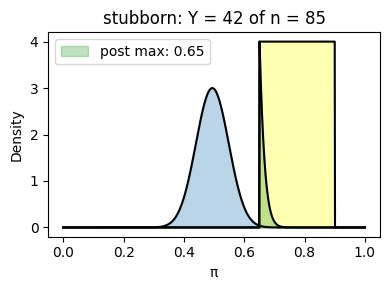

In [75]:
# Define a range of values for π
pi_values = np.linspace(0, 1, 1000)

fig, ax = plt.subplots(1, 1, figsize=(4, 3), sharey=True)

y, n = pass_test, N
likelihood = binom.pmf(y, n, pi_values)
prior = uniform.pdf(pi_values, loc = 0.65, scale=0.25)
posterior = Pmf(likelihood*prior)
posterior.normalize()

ax.plot(pi_values, prior, color="black")
ax.fill_between(pi_values, prior , alpha=0.3 , color="yellow")
ax.plot(pi_values, likelihood / max(likelihood) * 3, color="black")
ax.fill_between(pi_values, likelihood / max(likelihood) * 3, alpha=0.3, color="tab:blue")
ax.plot(pi_values, posterior/posterior.max()*max(prior), color="black")
ax.fill_between(pi_values, posterior/posterior.max()*max(prior), alpha=0.3, color="tab:green", label= f"post max: {posterior.argmax()/1000}")

ax.set_title(f"stubborn: Y = {y} of n = {n}")
ax.set_xlabel("π")
ax.set_ylabel("Density")
ax.legend()

plt.tight_layout()
plt.show()


<div style="background-color:#e0e1e0; padding:10px; border:5px solid #737773;color:black">
    
### Hot tip: How to avoid a regrettable prior model

#### Let π be some parameter of interest. No matter how much prior information you think you have about π or how informative you want to make your prior, be sure to assign non-0 plausibility to every possible value of π, even if this plausibility is near 0. For example, if π is a proportion which can technically range from 0 to 1, then your prior model should also be defined across this continuum.
</div>

# Exercises

**Exercise 1.** (Bechdel test). In this exercise we'll analyze $ \pi $, the proportion of films that pass the Bechdel test, using the `bechdel` data. For each scenario below, specify the posterior model of $ \pi $, and calculate the posterior mean and mode.

- **(a)** John has a flat $ \text{Beta}(1,1) $ prior and analyzes movies from the year 1980.
- **(b)** The next day, John analyzes movies from the year 1990, while building off their analysis from the previous day.
- **(c)** The third day, John analyzes movies from the year 2000, while again building off of their analyses from the previous two days.
- **(d)** Jenna also starts her analysis with a $ \text{Beta}(1,1) $ prior, but analyzes movies from 1980, 1990, 2000 all together in the same day.
- **(e)** Mike follows the John procedure, however, he does it in the inverse direction, from 2000 to 1980. Is it any difference with John posterior model?


**Exercise 2.** (Bechdel test). Create a 3×3 figure with nine plots showing the evolution of the Bechdel Test posterior over the decades. Generate a separate figure for each of the three original analysts: Feminist, Clueless, and Optimistic.

The process we've just taken, incrementally updating the analyst's posterior model of π, is referred to more generally as a **sequential Bayesian analysis or Bayesian learning**.

<div style="background-color:#e0e1e0; padding:10px; border:5px solid #737773;color:black">
    
### Sequential Bayesian analysis (aka Bayesian learning)

#### In a sequential Bayesian analysis, a posterior model is updated incrementally as more data come in. With each new piece of data, the previous posterior model reáecting our understanding prior to observing this data becomes the new prior model.
</div>

The ability to evolve as new data come in is one of the most powerful features of the Bayesian framework. These types of sequential analyses also uphold two fundamental and common sensical properties. First, the final posterior model is data order invariant, i.e., it isn't impacted by the order in which we observe the data. The second fundamental feature of a sequential analysis is that the final posterior only depends upon the cumulative data.



**Exercise 3.**  A shoe company develops a new internet ad for their latest sneaker. Three employees share the same $ \text{Beta}(4, 3) $ prior model for $ \pi $, the probability that a user will click on the ad when shown. However, the employees run three different studies, thus each has access to different data. The first employee tests the ad on 1 person – they do not click on the ad. The second tests 10 people, 3 of whom click on the ad. The third tests 100 people, 20 of whom click on the ad.

- **(a)** Sketch the prior pdf using. Describe the employees' prior understanding of the chance that a user will click on the ad.
- **(b)** Specify the unique posterior model of $ \pi $ for each of the three employees. We encourage you to construct these posteriors “from scratch”, i.e., without relying on the Beta-Binomial posterior formula.
- **(c)** Plot the prior pdf, likelihood function, and posterior pdf for each employee.
- **(d)** Summarize and compare the employees' posterior models of $ \pi $.


**Exercise 4** (A sequential employee). The shoe company described in previous exercise brings in a fourth employee. They start with the same $ \text{Beta}(4, 3) $ prior for $ \pi $ as the first three employees but, not wanting to recreate work, don't collect their own data. Instead, on their first day on the job, the new employee convinces the first employee to share their data. On the second day, they get access to the second employee's data, and on the third day, they get access to the third employee's data.

- **(a)** Suppose the new employee updates their posterior model of $ \pi $ at the end of each day. What's their posterior at the end of day one? At the end of day two? At the end of day three?
- **(b)** Sketch the new employee's prior and three (sequential) posteriors.  
  In words, describe how their understanding of $ \pi $ evolved over their first three days on the job.
- **(c)** Suppose instead that the new employee didn't update their posterior until the end of their third day on the job, after they'd gotten data from all three of the other employees. Specify their posterior model of $ \pi $ and compare this to the day three posterior from part (a).
